In [1]:
import scanpy as sc
import drug2cell as d2c
import blitzgsea as blitz

In [2]:
sc.settings.set_figure_params(dpi=80)

Drug2cell offers two independent sets of utility functions for assessing gene group activity in single cell data - **scoring** and **overrepresentation/enrichment**. This notebook will demonstrate both on PBMC3K demo data.

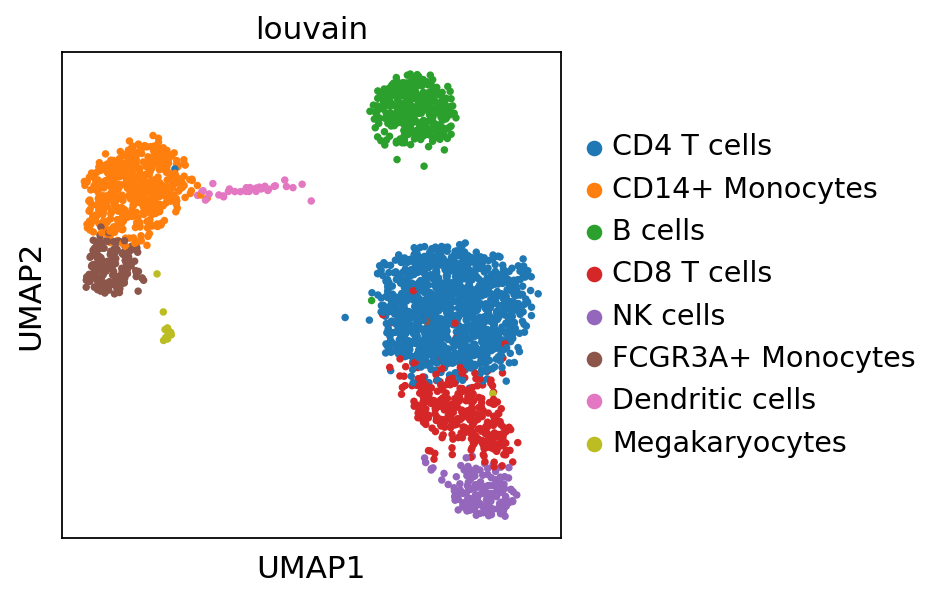

In [3]:
adata = sc.datasets.pbmc3k_processed()

sc.pl.umap(adata, color="louvain")

# Scoring

The scoring function efficiently computes the mean of the expression of each gene group in each cell. Can be directed to an appropriate location of log-normalised data via a combination of the `layer` and `use_raw` arguments.

By default, the function will load a set of ChEMBL drugs and their targets in a form distributed with the package.

In [4]:
d2c.score(adata, use_raw=True)

/home/jovyan/my-conda-envs/d2c/lib/python3.8/site-packages/d2c/__init__.py:209: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata.uns['drug2cell'] = anndata.AnnData(scores, obs=adata.obs)


`d2c.score()` creates a fully fledged AnnData object in `adata.uns['drug2cell']` with the gene groups as the feature space. The original object's `.obs` and `.obsm` get copied over for ease of downstream use. Let's use the existing UMAP to visualise a drug.

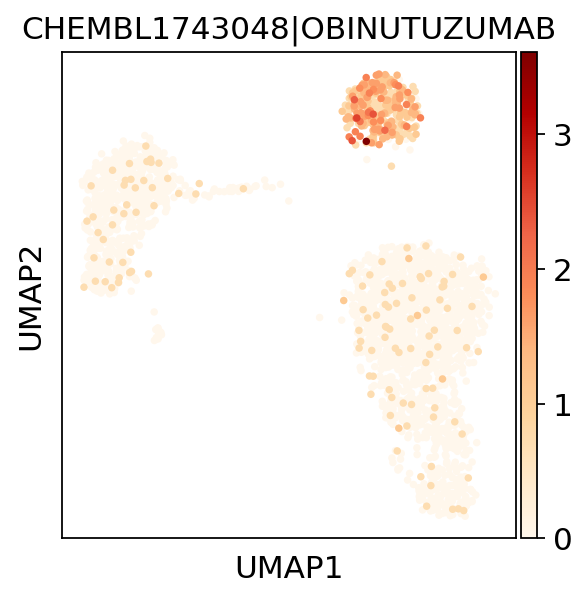

In [5]:
sc.pl.umap(adata.uns['drug2cell'], color="CHEMBL1743048|OBINUTUZUMAB", color_map="OrRd")

We can use the new object to run differential expression analysis, getting gene groups that are up-regulated in particular clusters.

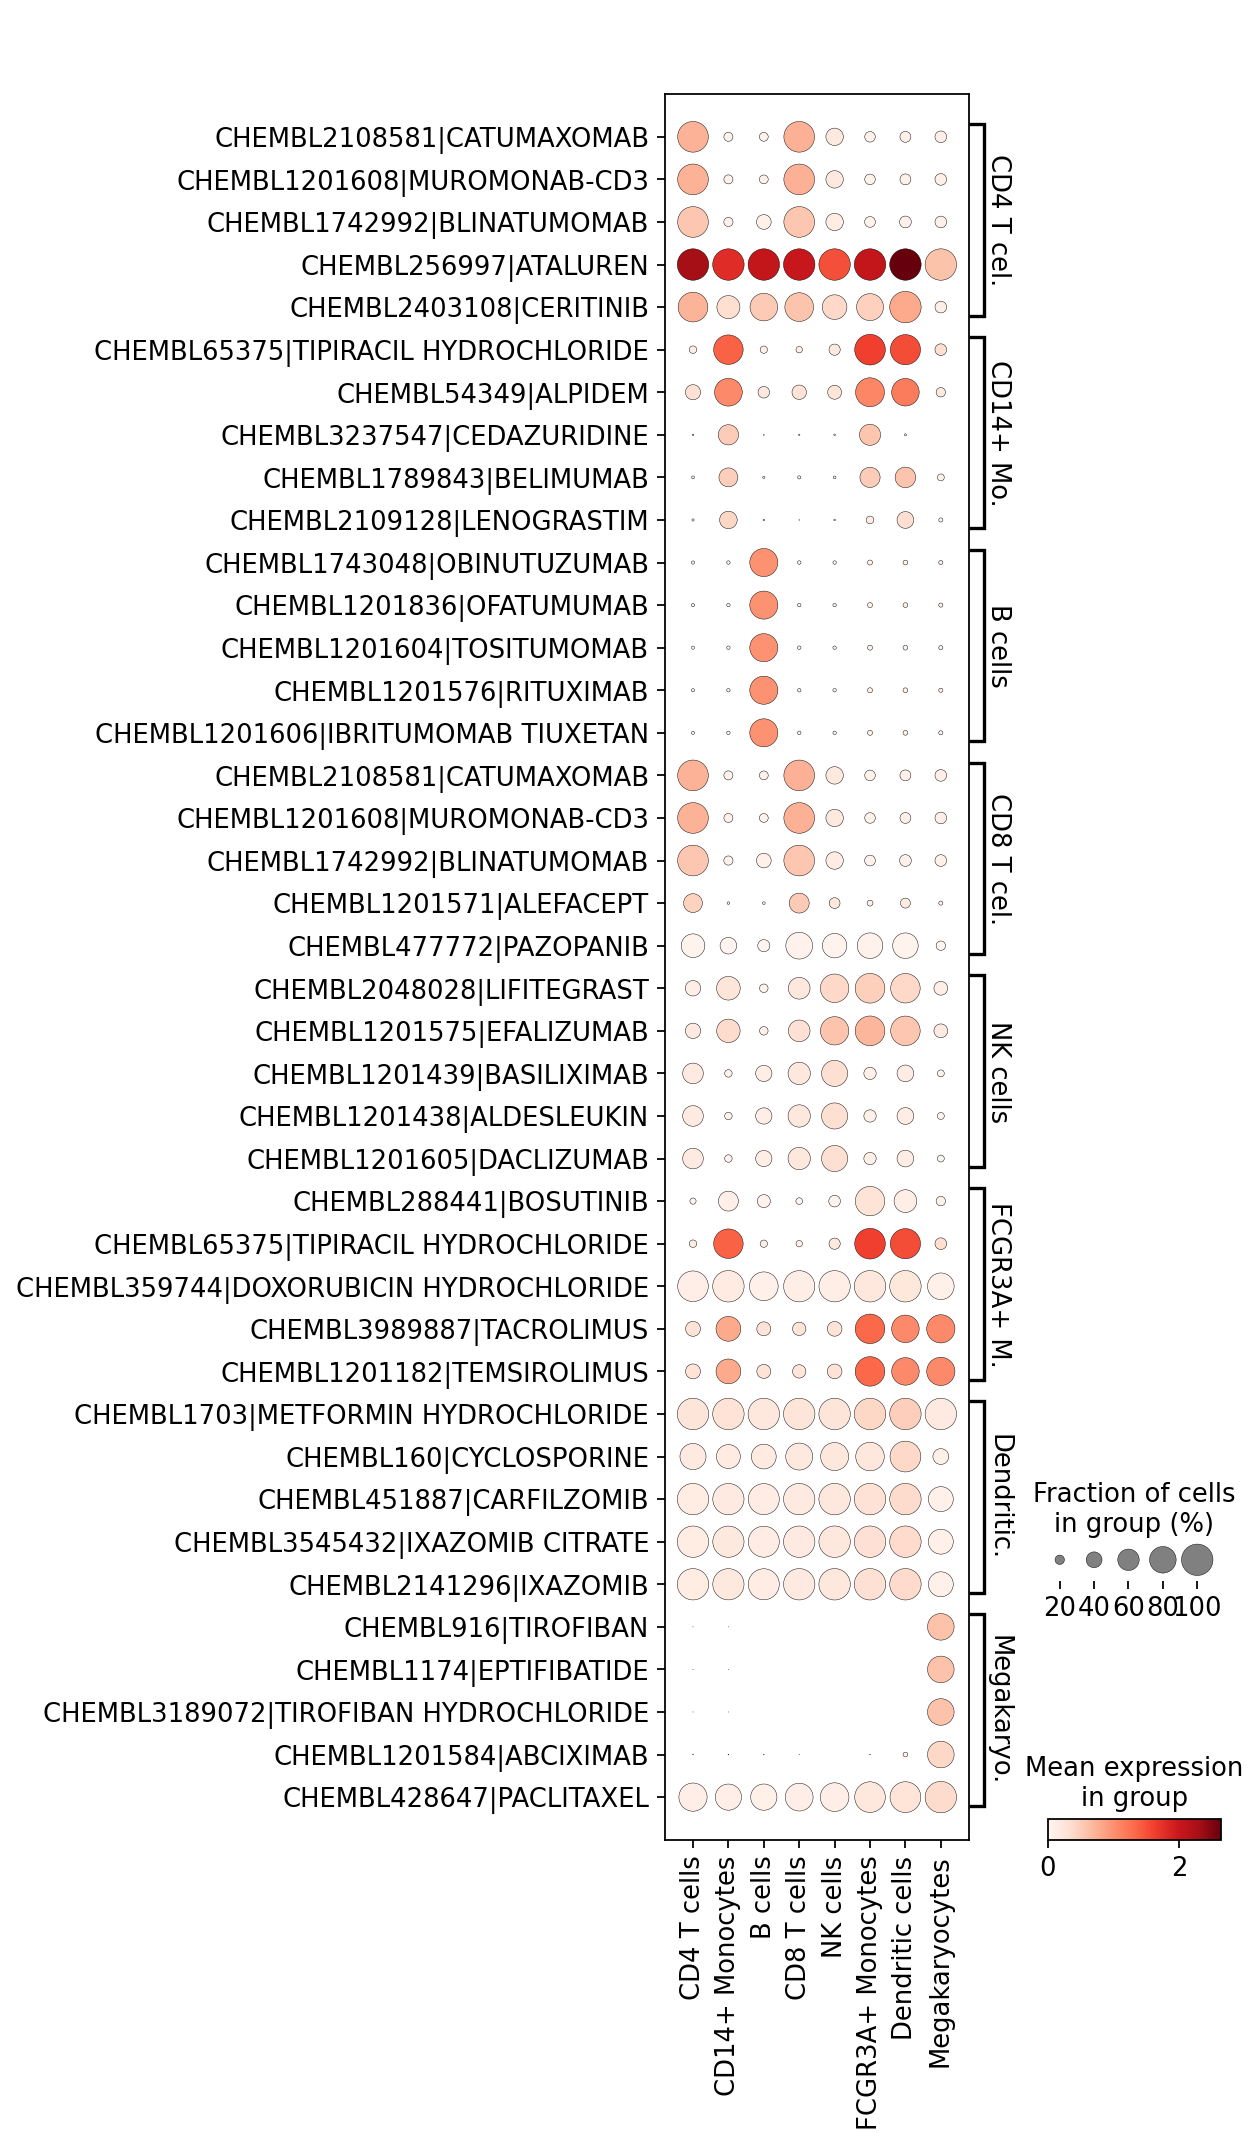

In [6]:
sc.tl.rank_genes_groups(adata.uns['drug2cell'], method="wilcoxon", groupby="louvain")
sc.pl.rank_genes_groups_dotplot(adata.uns['drug2cell'], swap_axes=True, dendrogram=False, n_genes=5)

If working with the ChEMBL drug targets and aiming to plot complete ATC groups, there's a helper function within drug2cell which prepares some extra arguments for use in scanpy plotting. Passing them to the visualising functions selects the appropriate compounds and groups them nicely. The syntax to do so is catching the output of `d2c.util.prepare_plot_args()` into a variable, and then passing that variable into a plotting function with `**` at the start, like below.

It's possible to subset this drug space based on their ATC level 1 and 2 categorisation by use of the `categories` argument.

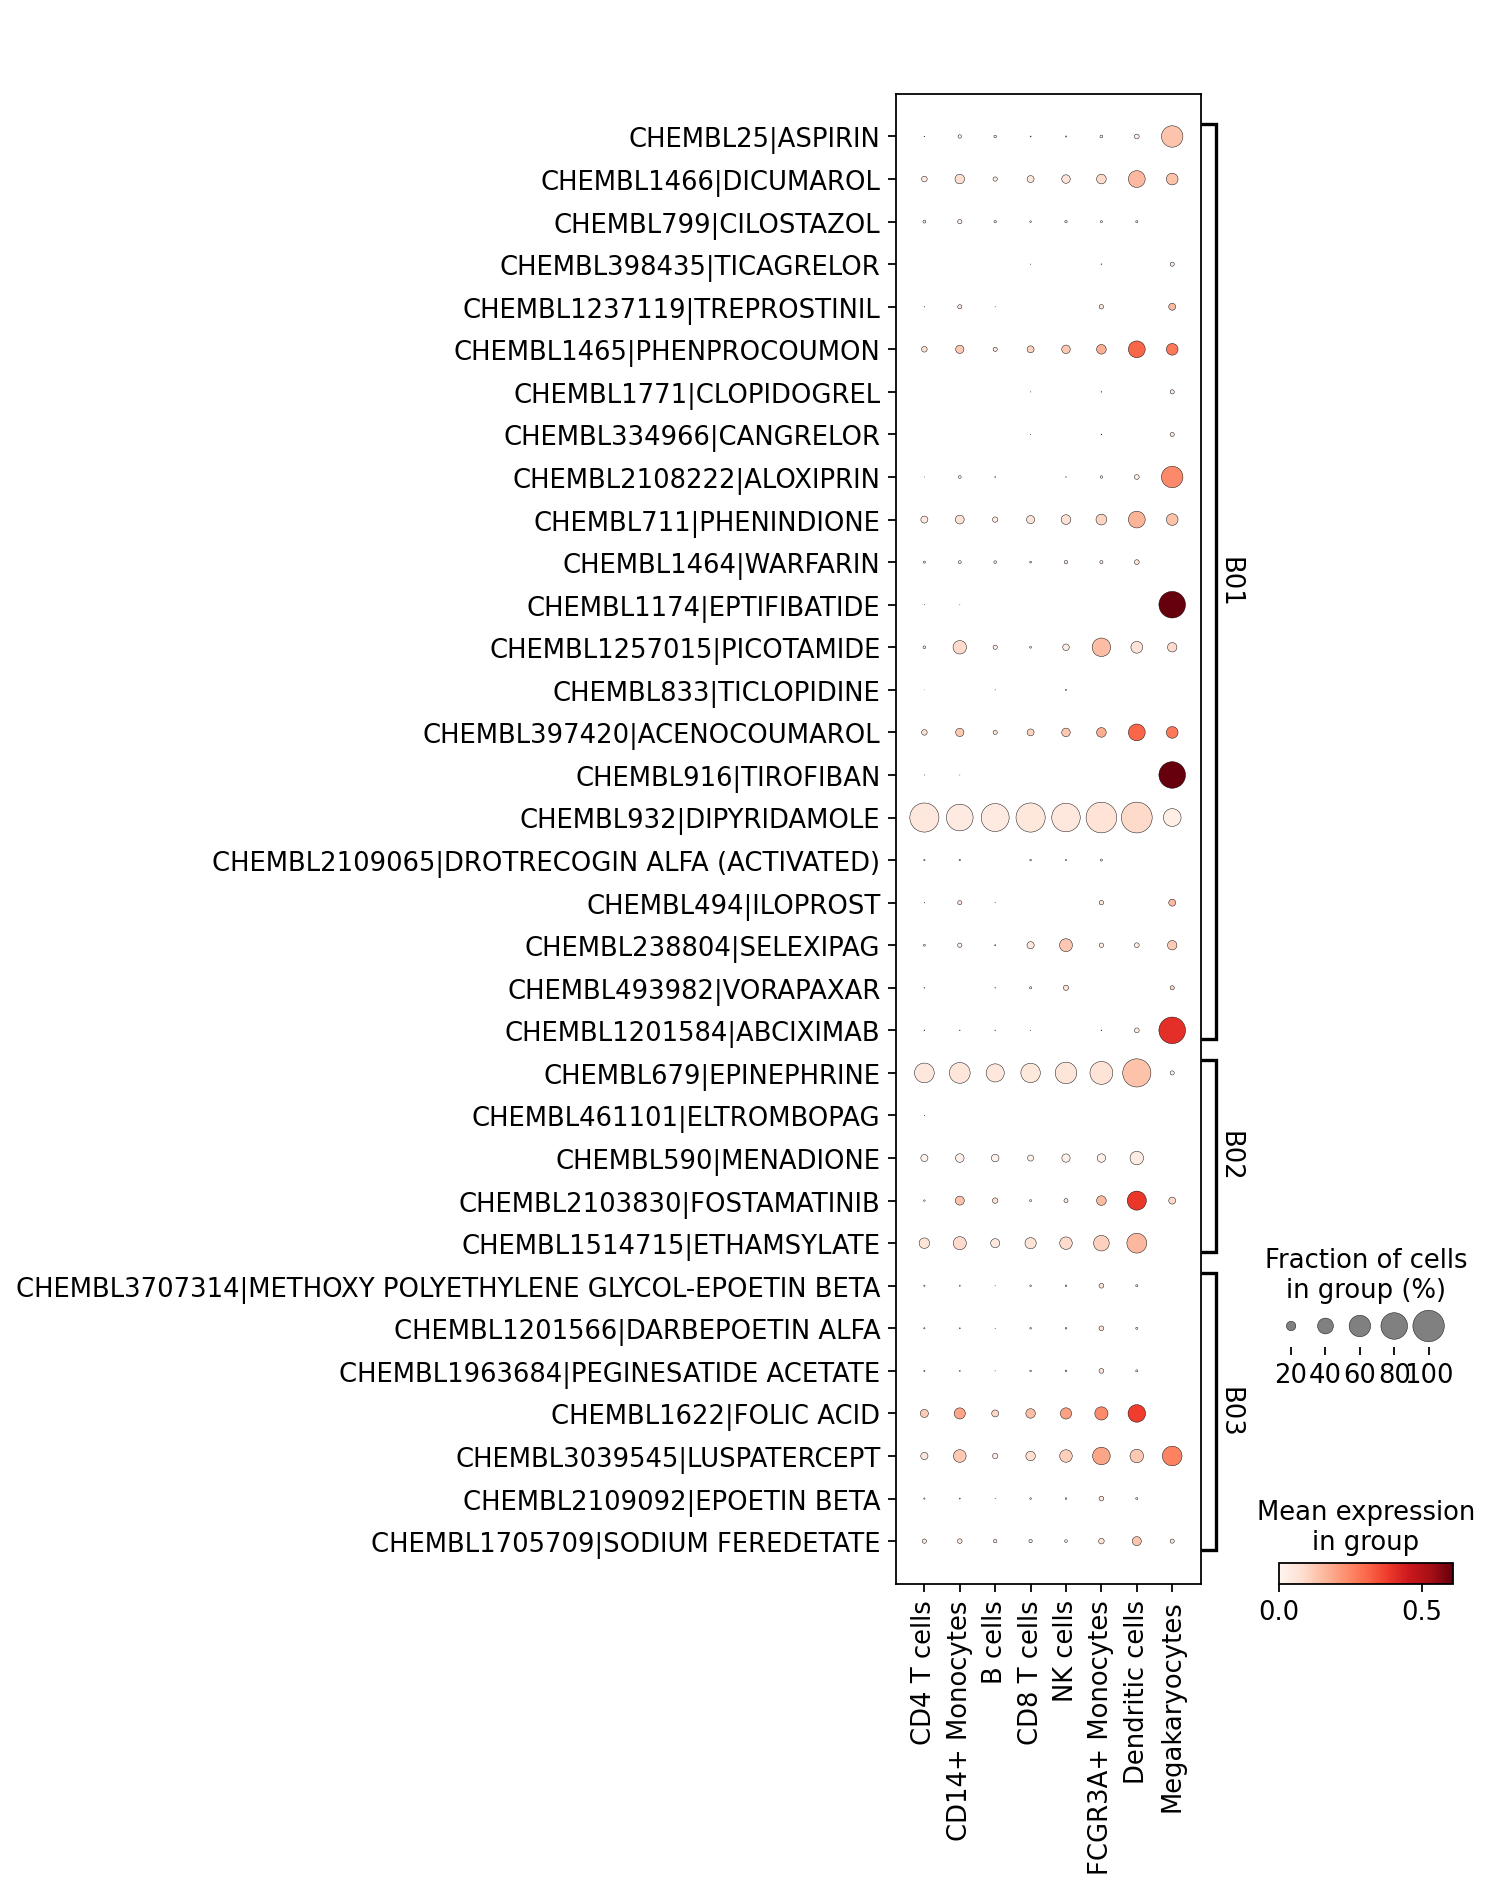

In [7]:
plot_args = d2c.util.prepare_plot_args(adata.uns['drug2cell'], categories=["B01","B02","B03"])
sc.pl.dotplot(adata.uns['drug2cell'], groupby="louvain", swap_axes=True, **plot_args)

# Specifying gene groups

It's possible to use drug2cell to score any gene groups of choice. All it takes is a dictionary with the group names as keys and corresponding gene membership lists as items.

This is the same format as the ~200 various libraries of gene sets distributed within `blitzgsea.enrichr`. Let's load one and take a look at the formatting.

In [8]:
targets = blitz.enrichr.get_library("GO_Molecular_Function_2021")
targets["MHC CLASS II RECEPTOR ACTIVITY (GO:0032395)"]

['HLA-DRA',
 'HLA-DPA1',
 'HLA-DQB1',
 'HLA-DOB',
 'HLA-DRB3',
 'HLA-DQA2',
 'HLA-DOA',
 'HLA-DQA1',
 'HLA-DQB2',
 'HLA-DRB1']

It's now possible to run drug2cell's scoring with these gene groups, passing them as the `targets` argument.

/home/jovyan/my-conda-envs/d2c/lib/python3.8/site-packages/d2c/__init__.py:209: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata.uns['drug2cell'] = anndata.AnnData(scores, obs=adata.obs)


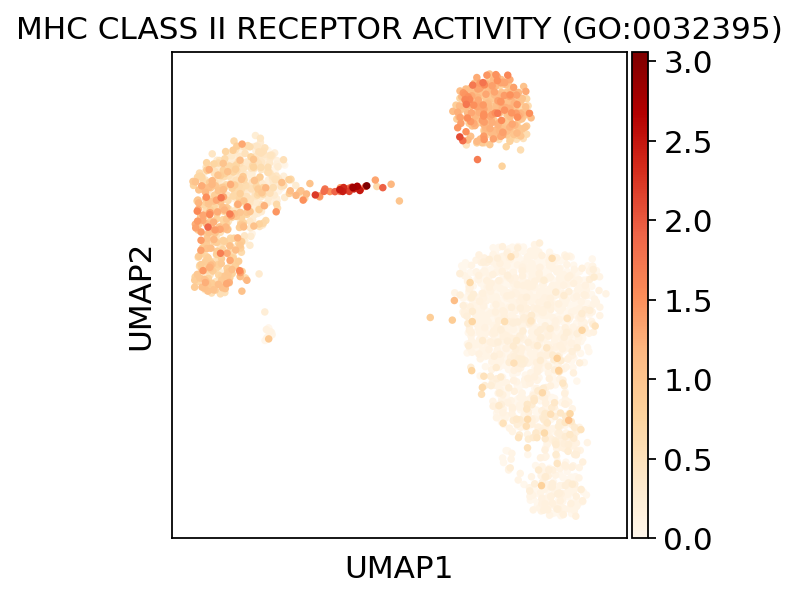

In [9]:
d2c.score(adata, targets=targets, use_raw=True)
sc.pl.umap(adata.uns['drug2cell'], color="MHC CLASS II RECEPTOR ACTIVITY (GO:0032395)", color_map="OrRd")

# Overrepresentation/enrichment

Please ensure you've ran `sc.tl.rank_genes_groups()` on your gene space object prior to commencing these analyses.

In [10]:
#this is an old object, so it will benefit from having an up-to-date marker detection performed on it
sc.tl.rank_genes_groups(adata, method="wilcoxon", groupby="louvain", use_raw=True)

Seeing how both the marker genes and gene group memberships are sets, it's possible to compute an overlap between them and evaluate its significance. This can be accomplished via the hypergeometric test, and drug2cell comes with a function to do that.

`d2c.hypergeometric()` can either accept a `targets` dictionary like `d2c.score()`, or read gene groups embedded within the `d2c.score()` output. As such, it can be ran without needing to perform scoring first if so desired, as overrepresentation analysis answers a different question.

The output is a dictionary of data frames with the clusters used to compute the markers in the original expression space as the keys.

In [11]:
overrepresentation = d2c.hypergeometric(adata)
overrepresentation["B cells"]

,intersection,gene_group,markers,universe,pvals,pvals_adj
OXIDOREDUCTION-DRIVEN ACTIVE TRANSMEMBRANE TRANSPORTER ACTIVITY (GO:0015453),26,51,695,13714,1.002258e-20,1.244804e-17
MHC CLASS II PROTEIN COMPLEX BINDING (GO:0023026),11,17,695,13714,4.907349e-11,3.047464e-08
ACTIVE ION TRANSMEMBRANE TRANSPORTER ACTIVITY (GO:0022853),12,22,695,13714,1.058699e-10,4.383013e-08
NADH DEHYDROGENASE (QUINONE) ACTIVITY (GO:0050136),14,33,695,13714,2.162179e-10,4.983781e-08
NADH DEHYDROGENASE (UBIQUINONE) ACTIVITY (GO:0008137),14,33,695,13714,2.162179e-10,4.983781e-08
...,...,...,...,...,...,...
GAP JUNCTION HEMI-CHANNEL ACTIVITY (GO:0055077),0,1,695,13714,1.000000e+00,1.000000e+00
GAP JUNCTION CHANNEL ACTIVITY (GO:0005243),0,1,695,13714,1.000000e+00,1.000000e+00
GAMMA-TUBULIN BINDING (GO:0043015),1,22,695,13714,6.817960e-01,1.000000e+00
MHC CLASS IB PROTEIN BINDING (GO:0023029),0,5,695,13714,1.000000e+00,1.000000e+00


The package also comes with a wrapper for running GSEA (gene set enrichment analysis), carried out via `blitzgsea`. GSEA is a more advanced alternative to conventional overrepresentation testing, taking the genes ordered by their marker scores and assessing the distribution of the gene group members in it.

``d2c.gsea()`` yields two pieces of output by default. ``enrichment`` is a result data frame dictionary akin to what came out put ``d2c.hypergeometric()`` above, and ``plot_gsea_args`` is a plot-minded collection of arguments that can be passed to ``d2c.util.plot_gsea()`` not unlike what was done earlier with the ATC categories helper function.

In the plots, the left side of the bar is genes with high positive scores, and the right side of the bar is genes with high negative scores. Scores near zero do not necessarily fall in the middle, this just represents the ranked order.

Enrichment : 100%|██████████| 1274/1274 [00:01<00:00, 977.15it/s]


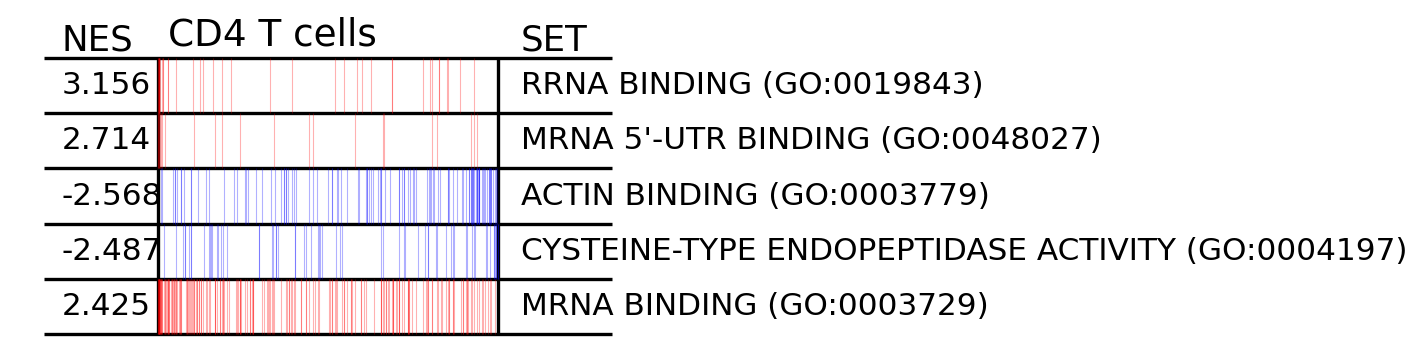

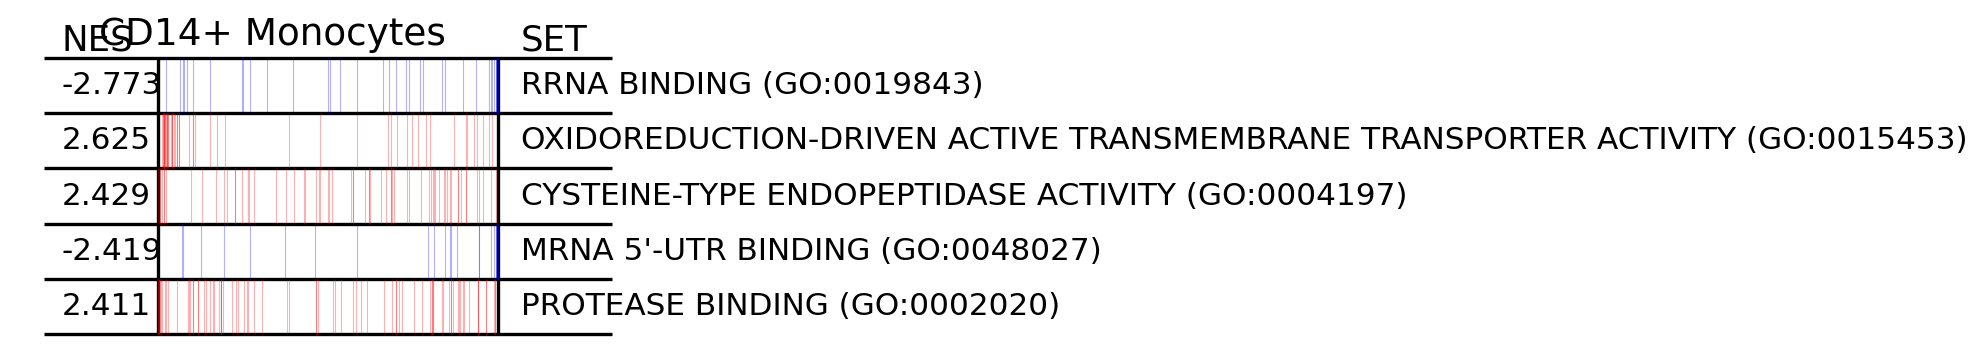

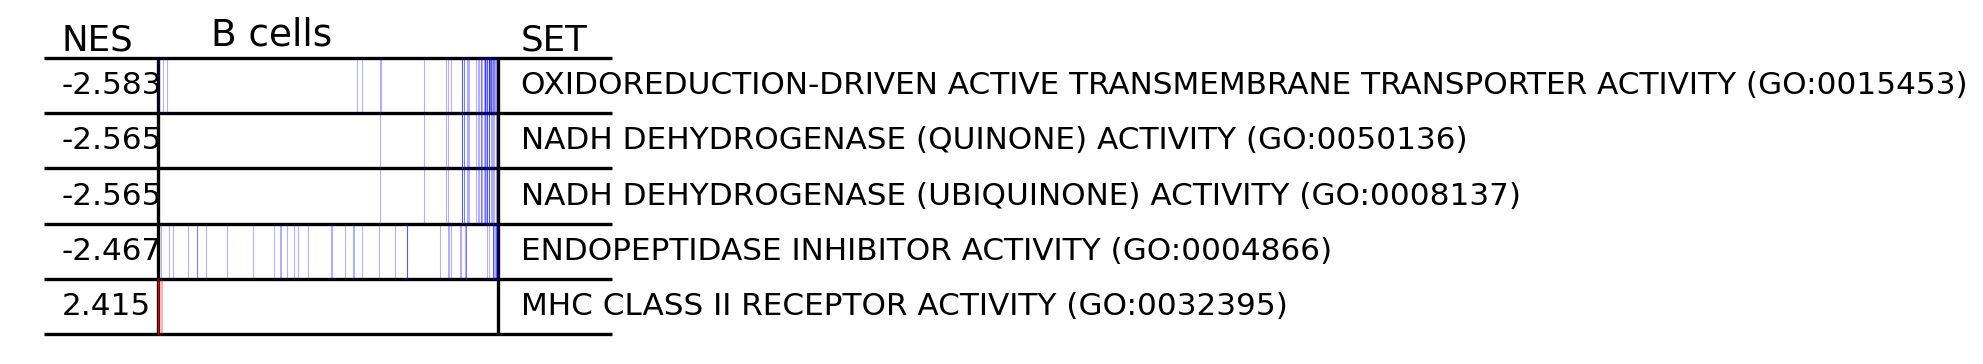

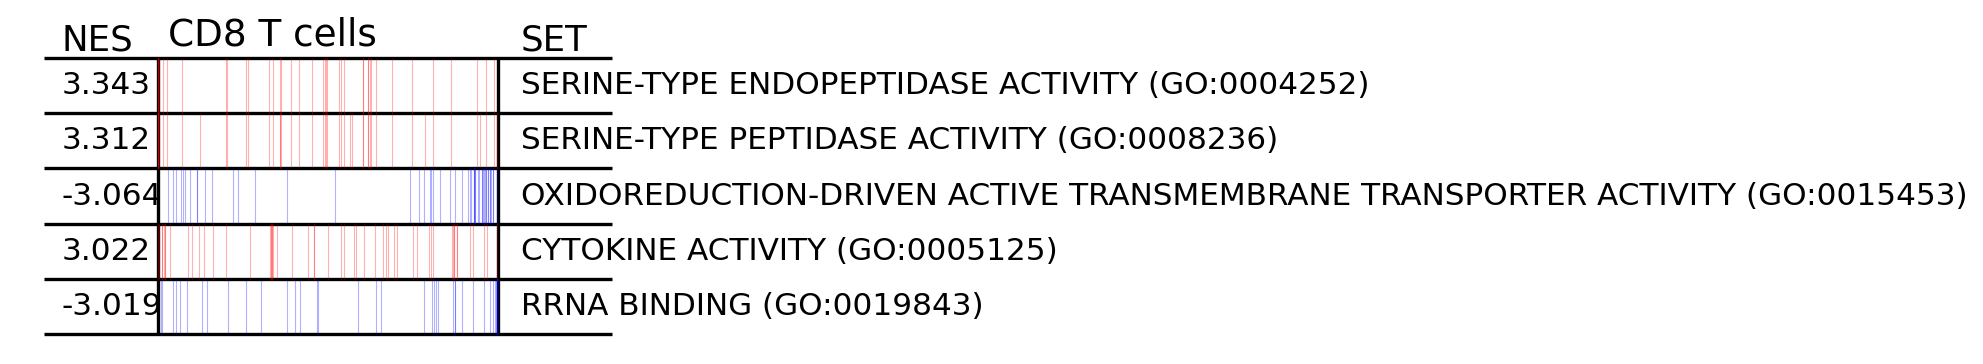

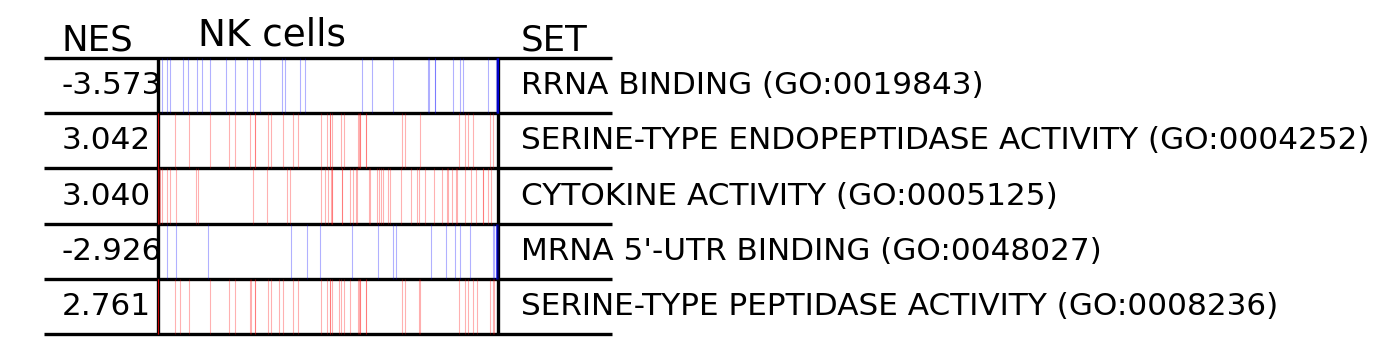

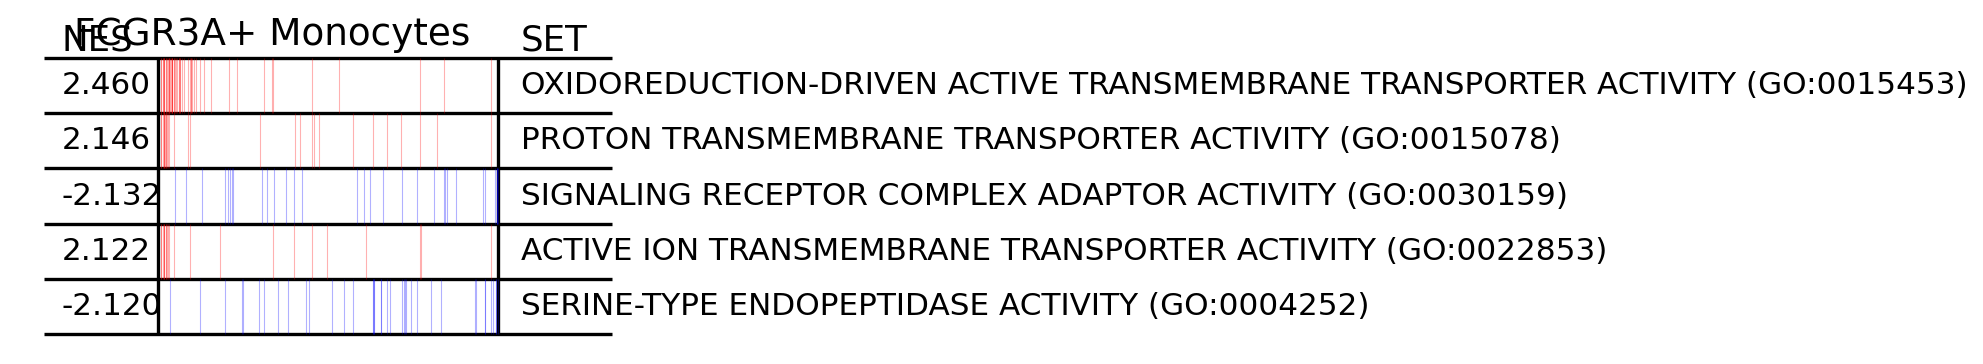

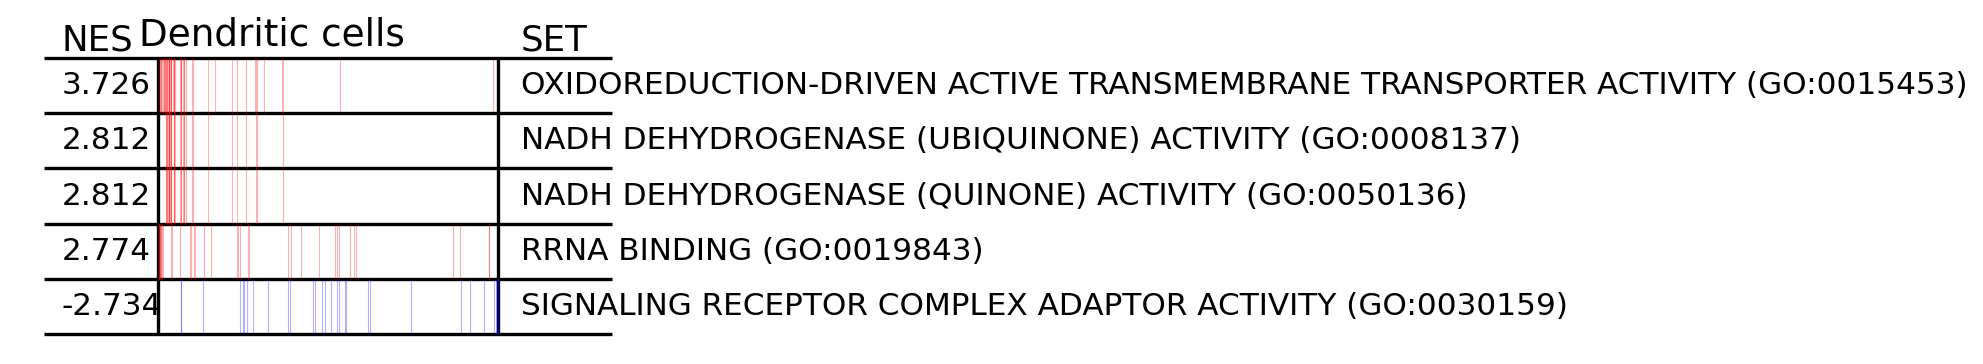

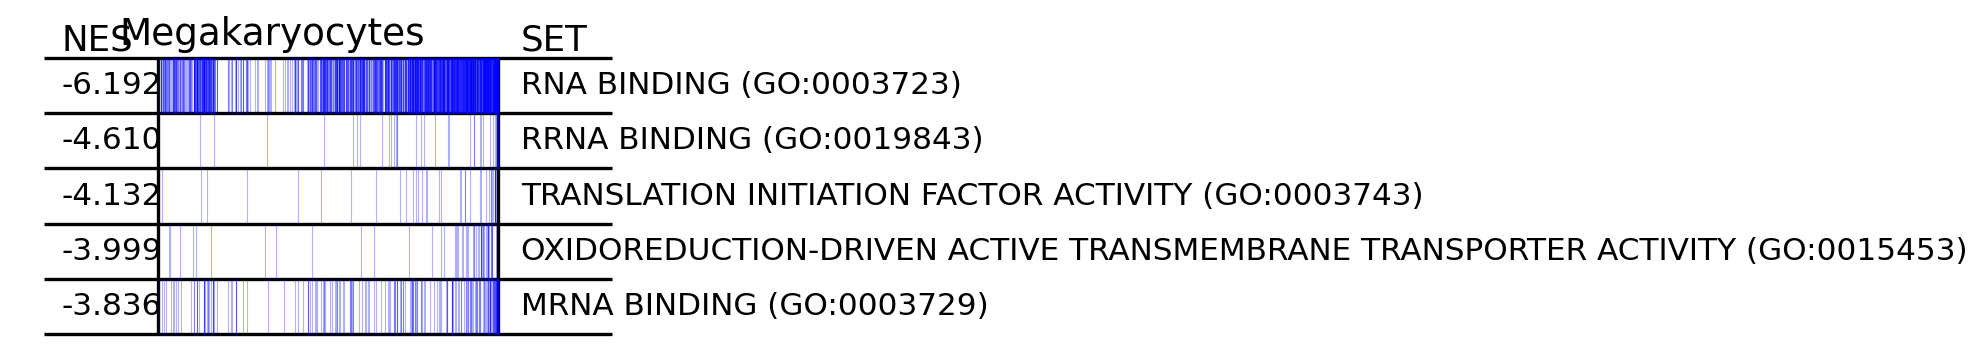

In [12]:
#remove the score space object for illustration purposes
#that it's really possible to run these functions with just the targets passed
del adata.uns['drug2cell']

enrichment, plot_gsea_args = d2c.gsea(adata, targets=targets)
d2c.util.plot_gsea(enrichment, n=5, **plot_gsea_args)

`plot_gsea_args` is just a dictionary with `targets` and `scores`, where `scores` has groups as keys and the corresponding GSEA gene input as values. It's possible to use those values to call other `blitzgsea` plotting.

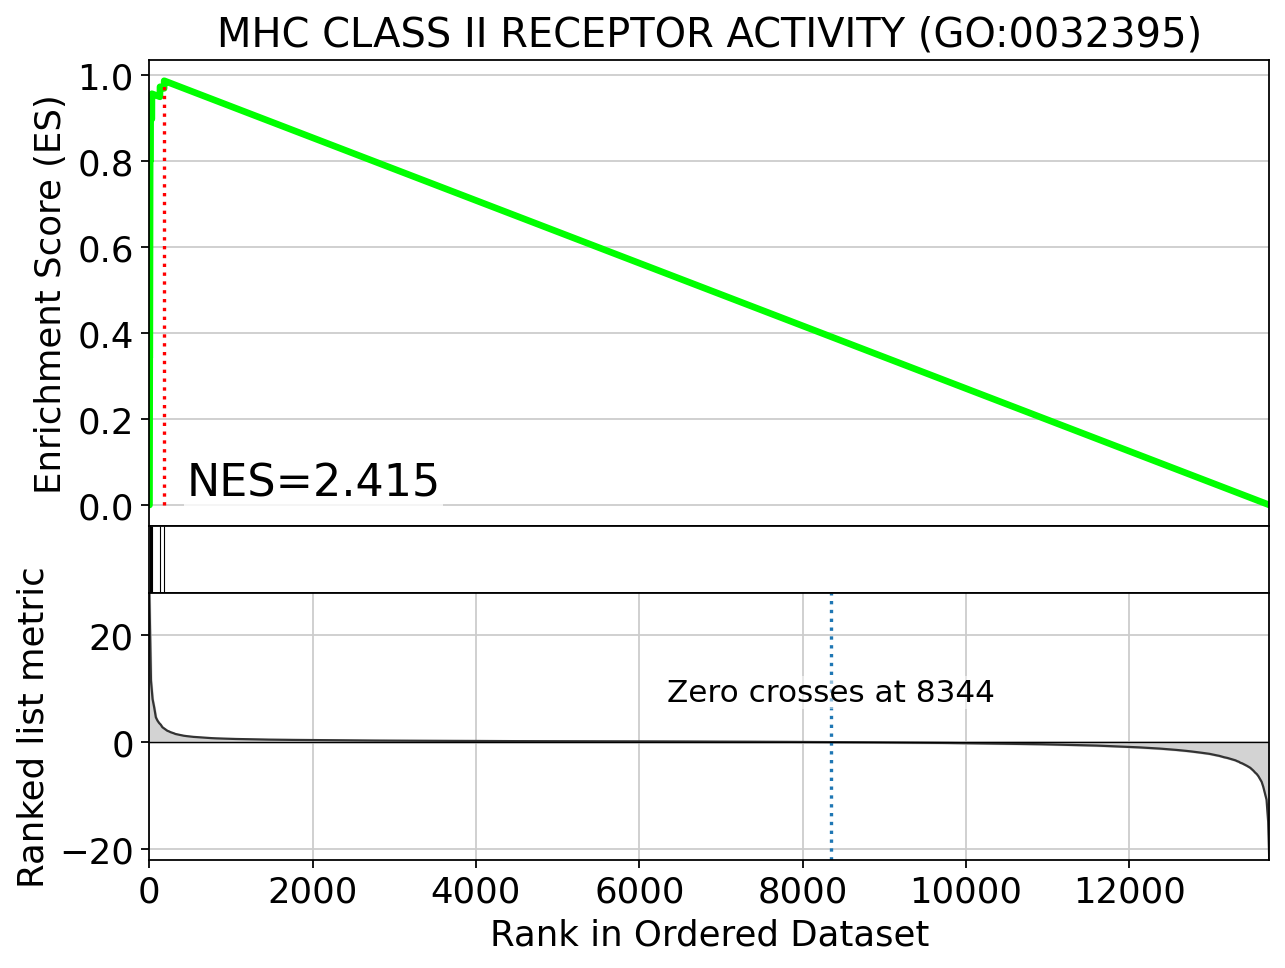

In [13]:
fig = blitz.plot.running_sum(
    signature = plot_gsea_args['scores']['B cells'],
    library = plot_gsea_args['targets'],
    result = enrichment['B cells'],
    geneset = "MHC CLASS II RECEPTOR ACTIVITY (GO:0032395)"
)
fig.show()